In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import VarianceThreshold,SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
fs1_data=pd.read_csv('/content/diabetes.csv')

In [3]:
fs1_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
fs1_data.shape

(768, 9)

In [5]:
fs1_data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [13]:
missing_ratio =fs1_data.isnull().mean()*100
features_remove =missing_ratio[missing_ratio > 30].index.tolist()
print("Features to remove here are:",features_remove)
data_reduced =fs1_data.drop(columns=features_remove)
print("Reduced dataset shape:",data_reduced.shape)


Reduced dataset shape: (768, 9)


In [16]:
M =data_reduced.drop(columns=['Outcome'])
n =data_reduced['Outcome']
M_train,M_test,n_train,n_test =train_test_split(M,n,test_size=0.2,random_state=42)
mdl =LogisticRegression(max_iter=1000)
mdl.fit(M_train,n_train)
n_pred =mdl.predict(M_test)
accuracy =accuracy_score(n_test,n_pred)
print("Accuracy after removing null features:", accuracy)


Accuracy after removing null features: 0.7467532467532467


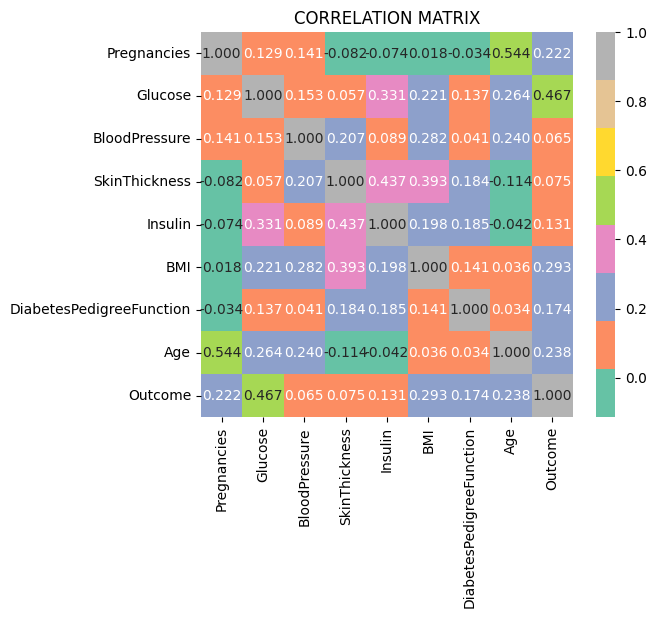

Model accuracy after removing features with high correlation values: 0.7467532467532467


In [8]:
cor_matrix =fs1_data.corr()
plt.figure(figsize=(6,5))
sns.heatmap(cor_matrix, annot=True,cmap='Set2',fmt=".3f")
plt.title("CORRELATION MATRIX")
plt.show()
cor_matrix =fs1_data.corr().abs()
upr_t =cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
to_drop =[column for column in upr_t.columns if any(upr_t[column]>0.8)]
filter_data =fs1_data.drop(columns=to_drop)
acc =accuracy_score(n_test,n_pred)
print("Model accuracy after removing features with high correlation values:", acc)


In [9]:
selector =VarianceThreshold(threshold=0.5)
M_filtr =filter_data.drop('Outcome', axis=1)
selector.fit(M_filtr)
select_features =M_filtr.columns[selector.get_support(indices=True)]
final_filter_data =filter_data[select_features]
print(f"No.of features selected after Low Variance Filter:7")
M =final_filter_data
n =filter_data['Outcome']
print("Selected Features after low variance filter are:", select_features)

No.of features selected after Low Variance Filter:7
Selected Features after low variance filter are: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age'],
      dtype='object')


In [10]:
mdl = LogisticRegression()
sfs_fd =SequentialFeatureSelector(mdl,direction='forward',scoring='accuracy')
sfs_fd.fit(M,n)
selected_features_forward =M.columns[sfs_fd.get_support()]
fd_select_data =M[selected_features_forward]
sfs_bd =SequentialFeatureSelector(mdl,direction='backward',scoring='accuracy')
sfs_bd.fit(M,n)
select_features_bd =M.columns[sfs_bd.get_support()]
bd_select_data =M[select_features_bd]

M_train_fd,M_test_fd,n_train_fd,n_test_fd =train_test_split(fd_select_data,n,test_size=0.2,random_state=42)
model_fd =LogisticRegression()
model_fd.fit(M_train_fd,n_train_fd)
n_pred_fd =model_fd.predict(M_test_fd)
acc_fd =accuracy_score(n_test_fd,n_pred_fd)
print(f"Selected features after Forward Selection are/is:{selected_features_forward}")
print(f"Accuracy value after Forward Selection is:{acc_fd}")

Selected features after Forward Selection are/is:Index(['Glucose', 'BMI', 'Age'], dtype='object')
Accuracy value after Forward Selection is:0.7467532467532467


In [11]:
M_train_bd,M_test_bd,n_train_bd,n_test_bd =train_test_split(bd_select_data,n,test_size=0.2,random_state=42)

mdl_bd =LogisticRegression()
mdl_bd.fit(M_train_bd,n_train_bd)
n_pred_bd =mdl_bd.predict(M_test_bd)
print(f"Selected features after Backward Selection are/is:{select_features_bd}")
acc_bd =accuracy_score(n_test_bd,n_pred_bd)
print(f"Accuracy value after Backward Selection is:{acc_bd}")

Selected features after Backward Selection are/is:Index(['Glucose', 'BloodPressure', 'BMI', 'Age'], dtype='object')
Accuracy value after Backward Selection is:0.7402597402597403


In [12]:
mdl =RandomForestClassifier(random_state=42)
mdl.fit(M_train,n_train)
imps=mdl.feature_importances_
feature_names =M_train.columns
feature_imp_df =pd.DataFrame({'Feature':feature_names,'Importance': imps})
feature_imp_df =feature_imp_df.sort_values(by='Importance',ascending=False)
print(feature_imp_df)
top_features =feature_imp_df.head(5)['Feature'].tolist()
print("5 most important features of model are:", top_features)

M_train_reduced =M_train[top_features]
M_test_reduced =M_test[top_features]
mdl_reduced =RandomForestClassifier(random_state=42)
mdl_reduced.fit(M_train_reduced,n_train)

n_pred_reduced =mdl_reduced.predict(M_test_reduced)

acc_val =accuracy_score(n_test,n_pred_reduced)
print("Model accuracy with top 5 features:",acc_val)

                    Feature  Importance
1                   Glucose    0.258864
5                       BMI    0.169984
7                       Age    0.140931
6  DiabetesPedigreeFunction    0.123768
2             BloodPressure    0.088134
0               Pregnancies    0.076551
4                   Insulin    0.076122
3             SkinThickness    0.065646
5 most important features of model are: ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure']
Model accuracy with top 5 features: 0.7792207792207793
